In [124]:
import numpy as np
import lz4
import nibabel
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO

In [522]:
def init_weights(m):
    if (type(m) == nn.Conv3d or
        type(m) == nn.ConvTranspose2d or
        type(m) == nn.Conv2d
       or type(m)== nn.Linear):
        nn.init.kaiming_normal_(m.weight,mode='fan_in',a=.01,nonlinearity="leaky_relu")
        nn.init.zeros_(m.bias)

In [523]:
def crop(x,x1,x2,y1,y2,z1,z2):
    return x[x1:x2,y1:y2,z1:z2]
def downsample(x,factorx,factory=None,factorz=None):
    if factory==None:
        factory=factorx
    if factorz==None:
        factorz=factorx
    return x[::factorx,::factory,::factorz]
def brain_slice(x,slice_num):
    return x[:,:,slice_num]
def normalize(x,norm_type=None):
    x-=np.min(x,keepdims=True)
    x/=(np.max(x,keepdims=True)+.00001)
    return x
    
def load_one_brain(path):
    img=nibabel.load(path)
    img=img.get_fdata()
    
    print(img.shape)
    img=crop(img,50,178,50,178,12,140)
    print(img.shape)
    return img


In [524]:
def view_slice(volume,slice_num):
    plt.imshow(volume[:,:,slice_num],cmap="Greys")

In [525]:
basic_brain=load_one_brain("/usr/local/faststorage/BraTS19_Data/Training/Data/BraTS19_2013_3_1/BraTS19_2013_3_1_flair.nii.gz")


(240, 240, 155)
(128, 128, 128)


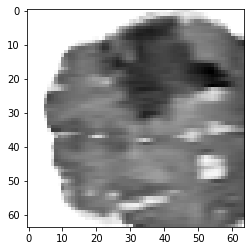

In [526]:
view_slice(downsample(basic_brain,2),32)

In [590]:
class Encoder(nn.Module):
    def __init__(self, z_dim=64,k=4):
        super().__init__()
        self.conv1=nn.Conv2d(1, k, kernel_size=3, stride=1)
        self.conv2=nn.Conv2d(k, 2*k, kernel_size=3, stride=2,padding=1)
        self.conv3=nn.Conv2d(2*k, 4*k, kernel_size=3, stride=2,padding=1)
        self.conv4=nn.Conv2d(4*k, 6*k, kernel_size=3, stride=2,padding=1)
        #self.fc1=nn.Linear(6*k*8*8,64)
        self.z_mean_fc=nn.Linear(16*6*k,z_dim)
        self.z_std_fc=nn.Linear(16*6*k,z_dim)
        self.ap=nn.AdaptiveAvgPool2d((4,4))
        self.lrelu=nn.LeakyReLU()
    def forward(self, xs):
        x=self.lrelu(self.conv1(xs))
        x=self.lrelu(self.conv2(x))
        x=self.lrelu(self.conv3(x))
        x=self.lrelu(self.conv4(x))
        x=self.ap(x)
        x=x.view(x.shape[0],-1)
        z_loc=self.z_mean_fc(x)
        z_scale=torch.exp(self.z_std_fc(x))
        return z_loc,z_scale

In [674]:
class Decoder(nn.Module):
    def __init__(self, z_dim=64,k=4):
        super().__init__()
        
        self.deconv1=torch.nn.ConvTranspose2d(z_dim, 6*k, kernel_size=4, stride=2,padding=1)
        self.deconv2=torch.nn.ConvTranspose2d(6*k, 4*k, kernel_size=4, stride=2,padding=1)
        self.deconv3=torch.nn.ConvTranspose2d(4*k, 2*k, kernel_size=4, stride=2,padding=1)
        self.deconv4=torch.nn.ConvTranspose2d(2*k, 2*k, kernel_size=4, stride=2,padding=1)
        self.deconv5=torch.nn.ConvTranspose2d(2*k, 2*k, kernel_size=4, stride=2,padding=1)
        self.deconv6=torch.nn.ConvTranspose2d(2*k, 2*k, kernel_size=4, stride=2,padding=1)
        self.conv1=torch.nn.Conv2d(2*k,2,kernel_size=3,stride=1,padding="same")

        self.relu = nn.ReLU()
        
        self.lrelu=nn.LeakyReLU()

        self.Sigmoid = nn.Sigmoid()
    def forward(self, z):
        z=z.unsqueeze(2).unsqueeze(3)
        #print(z)
        x = self.lrelu(self.deconv1(z))
        x = self.lrelu(self.deconv2(x))
        
        x = self.lrelu(self.deconv3(x))
        x = self.lrelu(self.deconv4(x))
        x = self.lrelu(self.deconv5(x))
        x = self.lrelu(self.deconv6(x))
        #print(x)
        x=self.conv1(x)
        #print(x.shape)
        recon_loc=x[:,0,...]
        recon_var=torch.exp(x[:,1,...])
        
        
        return recon_loc,recon_var
        


In [ ]:
class MLP(nn.Module):

In [679]:
class CVAE(nn.Module):
    def __init__(self, z_dim=64):
        super().__init__()
        self.encoder = Encoder(z_dim,k=2)
        self.encoder.apply(init_weights)
        self.decoder = Decoder(z_dim,k=2)
        self.decoder.apply(init_weights)

        #self.prior_net.train()
        #self.generation_net.train()
        self.z_dim=z_dim
        #self.recognition_net = Encoder(z_dim,k=4)
    def model(self, xs,age):
            # register this pytorch module and all of its sub-modules with pyro
            pyro.module("decoder",self.decoder)
            with pyro.plate("data",xs.shape[0]):
                z_loc = xs.new_zeros(torch.Size((xs.shape[0], self.z_dim)))
                z_scale = xs.new_ones(torch.Size((xs.shape[0], self.z_dim)))
                z = pyro.sample('latent', dist.Normal(z_loc, z_scale).to_event(1))

                loc,var = self.decoder(z)
                #print(var)
                pyro.sample('obs', dist.Normal(loc,var).to_event(3), obs=xs)
                #return loc
    def guide(self, xs,age):
            pyro.module("encoder",self.encoder)
            with pyro.plate("data",xs.shape[0]):
                z_loc, z_scale = self.encoder(xs)
                pyro.sample('latent', dist.Normal(z_loc, z_scale).to_event(1))
    def reconstruct(self,xs,age):
        z_loc, z_scale = self.encoder(xs)
        print(z_loc)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        print(z)
        # decode the image (note we don't sample in image space)
        loc,var=self.decoder(z)
        return loc


In [680]:
pyro.clear_param_store()
my_VAE=CVAE()
#cvae_net.to(device)
#optimizer = pyro.optim.Adam({"lr": learning_rate})
optimizer = pyro.optim.Adam({"lr": .001})
svi = SVI(my_VAE.model, my_VAE.guide, optimizer, loss=Trace_ELBO())

(128, 128, 128)
(64, 64, 128)
(64, 64)
0.0
0.99999
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.7552372  0.74125133 0.70628664]
 [0.         0.         0.         ... 0.58391024 0.44055503 0.27272455]
 [0.         0.         0.         ... 0.39859741 0.28321395 0.11188699]]


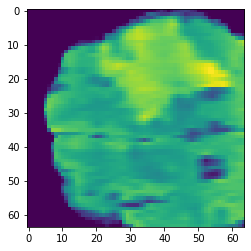

In [681]:
print(basic_brain.shape)
basic_brain_rs=downsample(basic_brain,2,2,1)
print(basic_brain_rs.shape)
basic_slice=brain_slice(basic_brain_rs,63)
print(basic_slice.shape)
norm_slice=normalize(basic_slice)
print(np.min(norm_slice))
print(np.max(norm_slice))
print(norm_slice)
plt.imshow(norm_slice)
resha_slice=np.reshape(norm_slice,(1,1,64,64))


In [688]:
losses=[]
for i in range(1000):
    loss=svi.step(xs=torch.Tensor((resha_slice)*1))
    losses.append(loss)
losses=np.asarray(losses)
print(np.mean(losses[0:10]),np.mean(losses[-10:]))

-5435.310618782043 -6509.197996711731


tensor([[-4.0641e-02,  4.2468e-01,  8.2240e-01,  2.5056e-01,  5.8134e-02,
          2.2489e-01, -6.2658e-01,  1.1647e-01,  3.6898e-02,  1.3102e-01,
          2.0736e-01, -1.1471e+00, -2.8329e-02, -2.8410e+00, -3.7214e-02,
         -1.1375e+00, -1.7540e+00, -4.7045e-02, -1.2902e-01, -8.8104e-02,
          6.8215e-01,  2.1996e-01,  9.4865e-01,  1.2725e+00,  2.0566e+00,
          7.5293e-01,  4.3677e-01, -4.4000e-02, -1.7048e-01, -5.4946e-01,
          4.7939e-01,  5.0299e-01, -3.6379e-02, -1.8398e-01, -3.8055e+00,
          1.9771e+00, -4.2279e-02,  1.6459e-01, -1.2028e+00, -7.1870e-02,
          4.6814e-01,  9.0640e-02, -1.4798e-01, -1.9256e-03, -6.8672e-02,
         -1.6793e-01,  2.3021e-01, -2.2470e-01,  3.7202e-02,  1.0293e+00,
         -1.5402e-01, -1.7652e-01, -1.7102e+00, -8.2607e-01, -1.4240e-01,
         -4.2743e-02, -8.7963e-01, -9.8226e-02,  2.9159e-01,  8.5162e-01,
          3.7010e-01,  5.9046e-01, -1.1445e+00,  1.7458e+00]],
       grad_fn=<AddmmBackward>)
tensor([[-1.2268e

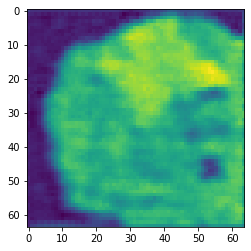

In [689]:
plt.imshow(my_VAE.reconstruct(torch.Tensor(resha_slice)).detach().numpy().squeeze())